# Example MOD16 Forward Run

This notebook demonstrates how to use the MOD16 Python implementation, `mod16`, to estimate evapotranspiration (ET) fluxes at 317 eddy covariance (EC) tower sites. To run this notebook, you'll need the following files:

- [MOD16 Collection 6.1 BPLUT](https://github.com/arthur-e/MOD16/blob/master/data/MOD16_BPLUT_C5.1_05deg_MCD43B_Albedo_MERRA_GMAO.txt) (Imported automatically, below)
- [VIIRS_MOD16_tower_site_latent_heat_and_drivers_v7.h5](https://doi.org/10.5281/zenodo.13988805) (Download from the public archive)

The `*.h5` (HDF5) file above contains the input driver data for 317 EC tower sites.

In [1]:
import datetime
import os
import numpy as np
import h5py
import mod16
from mod17.utils import rmsd
from mod16 import MOD16
from mod16.utils import pft_dominant, restore_bplut
from matplotlib import pyplot

N_SITES = 317
BPLUT = os.path.join(os.path.dirname(mod16.__file__), 'data/MOD16_BPLUT_C5.1_05deg_MCD43B_Albedo_MERRA_GMAO.csv')

# CHANGE THE FOLLOWING to match your file system:
DRIVERS_HDF5 = '/anx_lagr4/MODIS_VIIRS/calibration/VNP16_MOD16_tower_site_latent_heat_and_drivers_v7.h5'

**There are two types of interfaces in the MOD16 Python code.**

User-friendly methods of a `MOD16` instance, parameterized for a single land-cover type:

- `MOD16.evapotranspiration()`
- `MOD16.transpiration()`
- `MOD16.evaporation_soil()`
- `MOD16.evaporation_canopy()`
- And so on.

There is also a single, vectorized interface implemented as a static method of the `MOD16` class, which can handle multiple land-cover types:

- `MOD16._evapotranspiration()`
- `MOD16._et()` (alias for the function above)

The user-friendly, instance methods have code blocks that are easy to read and understand, but those methods might run slow for large spatial domains because they incur a lot of Python overhead. The values returned by those functions are in mass-flux units (kg [H2O] m-2 sec-1).

The vectorized interface is faster because it incurs less Python overhead; it is useful, for example, when calibrating MOD16, because this may require hundreds or thousands of function evaluations every second. It can also handle multiple land-cover types. The vectorized interface returns values in energy units (W m-2), for comparison to eddy covariance tower measurements.

## Simple, Non-Vectorized Example

The Biome Properties Lookup Table (BPLUT) defines the model parameters for 11 plant functional types (PFTs), or land-cover types. Consequently, when we read this file in using `restore_bplut()`, we get a Python dictionary where each parameter (key) is mapped to an array (value) of at least 11 values. Because the PFTs have numeric codes (e.g., 1 represents "Evergreen Needleleaf forest") starting with the number one, and because Python starts counting at zero, the very first value in each array is NaN. Similarly, the PFT code 11 represents a land-cover type we don't use, so the 11th position of the array is also NaN; however, PFT 12 is used so the 12th position has a valid number.

In [2]:
params_dict = restore_bplut(BPLUT)

# NOTE: This parameter was not a free parameter in MOD16 Collection 6.1; 
#    it was always set to 250
params_dict['beta'] = np.array([250] * 13)
params_dict

{'tmin_close': array([nan, -8., -8., -8., -6., -7., -8., -8., -8., -8., -8., nan, -8.]),
 'tmin_open': array([  nan,  8.31,  9.09, 10.44,  9.94,  9.5 ,  8.61,  8.8 , 11.39,
        11.39, 12.02,   nan, 12.02]),
 'vpd_open': array([  nan,  650., 1000.,  650.,  650.,  650.,  650.,  650.,  650.,
         650.,  650.,   nan,  650.]),
 'vpd_close': array([  nan, 3000., 4000., 3500., 2900., 2900., 4300., 4400., 3500.,
        3600., 4200.,   nan, 4500.]),
 'gl_sh': array([ nan, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.04, 0.04, 0.02,
         nan, 0.02]),
 'gl_wv': array([ nan, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.04, 0.04, 0.02,
         nan, 0.02]),
 'g_cuticular': array([   nan, 1.e-05, 1.e-05, 1.e-05, 1.e-05, 1.e-05, 1.e-05, 1.e-05,
        1.e-05, 1.e-05, 1.e-05,    nan, 1.e-05]),
 'csl': array([   nan, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.0055, 0.0055,
        0.0055, 0.0055, 0.0055,    nan, 0.0055]),
 'rbl_min': array([nan, 60., 60., 60., 60., 60., 60., 60., 60., 60., 6

**We can create our parameterized model instance by providing the model with a dictionary of parameters.** When using the `MOD16.evapotranspiration()` interface, we can only simulate one PFT at at time, so we'll have to reduce our dictionary to a simple collection key-value pairs where the value is a single, scalar value. In this case, we're interested just in Cereal Crops:

In [3]:
# Just the parameters for a Cereal Crop (PFT = 7)
cereal_params = dict([(key, value[7]) for key, value in params_dict.items()])
cereal_params

{'tmin_close': -8.0,
 'tmin_open': 8.8,
 'vpd_open': 650.0,
 'vpd_close': 4400.0,
 'gl_sh': 0.02,
 'gl_wv': 0.02,
 'g_cuticular': 1e-05,
 'csl': 0.0055,
 'rbl_min': 60.0,
 'rbl_max': 95.0,
 'beta': 250}

**In this example, we'll run the model for all 317 sites, even though most of them are not Cereal Crop sites, for simplicity.**

In [4]:
model = MOD16(cereal_params)
model

## An Easier Way to Get Started

Above, we saw how to stand-up a MOD16-like model from scratch, based on a BPLUT that we may have provided. We could also have simply created a parameters dictionary, `params_dict`, manually. If you want to use an established MOD16 model variant, however, the quickest way to get started is simply to import the model from `models.py`. For example, you can get straight to work with MODIS MOD16 Collection 6.1 like this:

In [5]:
from mod16.models import MOD16Collection61

# Use MODIS MOD16 Collection 6.1 for Croplands (PFT = 12)
model = MOD16Collection61(pft = 12)

# Soil evaporation near sea-level, at 20 deg C, VPD of 1000 Pa, fPAR of 0.5...
model.evaporation_soil(101e3, 293.15, 1000, 0.5, 100)

5.083295223395212e-06

A complete list of the PFTs that are pre-configured is available:

In [6]:
from mod16.models import PFT_ALL

PFT_ALL

{'Evergreen Needleleaf Forest (ENF)': 1,
 'Evergreen Broadleaf Forest (EBF)': 2,
 'Deciduous Needleleaf Forest (DNF)': 3,
 'Deciduous Broadleaf Forest (DBF)': 4,
 'Mixed Forest (MF) ': 5,
 'Closed Shrublands (CSH)': 6,
 'Open Shrublands (OSH)': 7,
 'Woody Savannas (WSV)': 8,
 'Savannas (SAV)': 9,
 'Grasslands (GRS)': 10,
 'Croplands (CRO)': 12}

### Loading Driver Datasets

Our HDF5 file contains the necessary driver data for running MOD16. Specifically, we use the following daily, surface meteorological data from the GEOS-IT re-analysis dataset:

- Net downward long-wave radiation integrated during daylight hours (W m-2)
- Net downward long-wave radiation integrated during nighttime hours (W m-2)
- Down-welling short-wave radiation integrated during daylight hours (W m-2)
- Down-welling short-wave radiation integrated during night-time hours (W m-2), assumed to be zero
- Down-welling short-wave albedo (under "black-sky" conditions)
- Daytime prevailing air temperature at 10-meter height (deg K)
- Nighttime prevailing air temperature at 10-meter height (deg K)
- Mean annual air temperature at 10-meter height (deg K)
- Minimum daily air temperature at 10-meter height (deg K)
- Daytime mean vapor pressure deficit (VPD) (Pa)
- Nighttime mean VPD (Pa)

An alternative to GEOS-IT data are [the publicly available MERRA-2 re-analysis data;](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/) they're quite similar.

The GEOS-IT (or MERRA-2)  data are provided hourly, so we generated the quantities above by intergrating hourly data during separate day-night periods. We'll also compute the following, using elevation information:

- Air pressure (Pa), based on elevation

Daily canopy characteristics come from either the MODIS or VIIRS sensor; either the MODIS MOD15 or VIIRS VNP15 products:

- Fraction of photosynthetically active radiation (PAR) absorbed by the vegetation canopy
- Leaf area index (LAI)

In [7]:
with h5py.File(DRIVERS_HDF5, 'r') as hdf:
    lw_net_day = hdf['GEOS-IT/LWGNT_daytime'][:]
    lw_net_night = hdf['GEOS-IT/LWGNT_nighttime'][:]
    sw_albedo = hdf['MODIS/MCD43GF_black_sky_sw_albedo'][:]
    sw_albedo = np.nanmean(sw_albedo, axis = -1)
    sw_rad_day = hdf['GEOS-IT/SWGDN'][:]
    sw_rad_night = 0
    temp_day = hdf['GEOS-IT/T10M_daytime'][:]
    temp_night = hdf['GEOS-IT/T10M_nighttime'][:]
    tmin = hdf['GEOS-IT/Tmin'][:]
    vpd_day = hdf['GEOS-IT/VPD_daytime'][:]
    vpd_night = hdf['GEOS-IT/VPD_nighttime'][:]
    temp_annual = hdf['GEOS-IT/T10M_annual_mean'][:]
    
    # Calculate air pressure as a function of elevation
    pressure = MOD16.air_pressure(hdf['state/elevation'][:])
    # In our case, we have a 2D array of elevation but just want one value per site
    pressure = pressure.mean(axis = -1)

We'll also read-in the fPAR and LAI data, as below. These could come from either the MODIS or VIIRS sensor(s).

In [8]:
with h5py.File(DRIVERS_HDF5, 'r') as hdf:
    # Read in fPAR, LAI, and convert from (%) to [0,1]
    fpar = np.nanmean(
        hdf['MODIS/MOD15A2HGF_fPAR_interp'][:], axis = -1)
    lai = np.nanmean(
        hdf['MODIS/MOD15A2HGF_LAI_interp'][:], axis = -1)
    # Convert fPAR from (%) to [0,1] and re-scale LAI; reshape fPAR and LAI
    fpar /= 100
    lai /= 10

Finally, we'll put all these driver datasets (NumPy arrays) into a list, for convenience.

In [9]:
# Compile driver datasets
drivers = [
    lw_net_day, lw_net_night, sw_rad_day, sw_rad_night, sw_albedo,
    temp_day, temp_night, temp_annual, tmin, vpd_day, vpd_night,
    pressure, fpar, lai
]

**One advantage of using the non-vectorized interfaces is that we get more granular estimates;** specifically, we can obtain separate daytime and nighttime ET estimates:

In [10]:
et_day, et_night = model.evapotranspiration(*drivers)
et_day.shape

/usr/local/dev/MOD16/mod16/__init__.py:764: RuntimeWarning: invalid value encountered in power
  r_corr = (101300 / pressure) * (temp_k / 293.15)**1.75
/usr/local/dev/MOD16/mod16/__init__.py:764: RuntimeWarning: invalid value encountered in power
  r_corr = (101300 / pressure) * (temp_k / 293.15)**1.75


(7305, 317)

Again, not all of these 317 sites are classified as having a dominant land-cover type of Cereal Crops, but the first site is. The output units of the `MOD16.evapotranspiration()` are in (water) mass flux units:

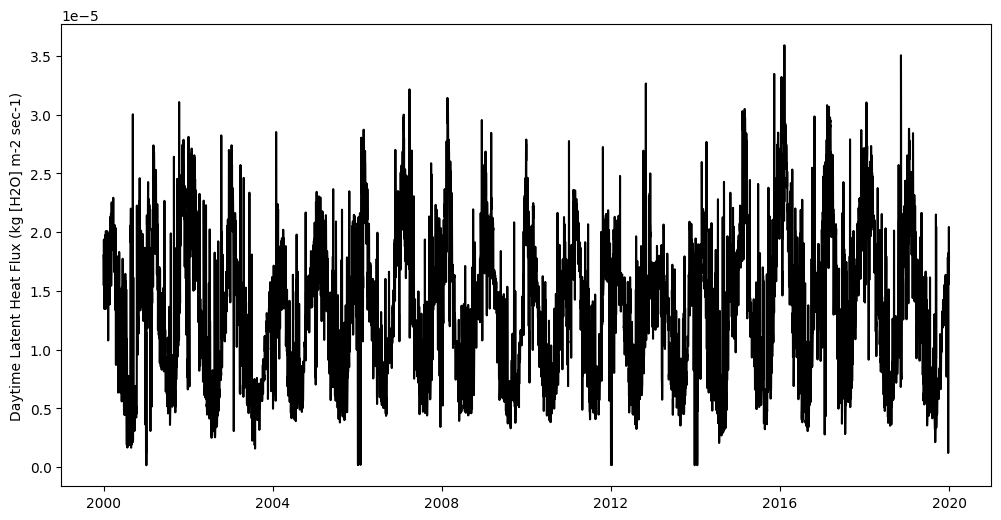

In [11]:
with h5py.File(DRIVERS_HDF5, 'r') as hdf:
    time = [datetime.date(y, m, d) for y, m, d in hdf['time'][:].tolist()]

pyplot.figure(figsize = (12, 6))
pyplot.plot(time, et_day[:,0], 'k-')
pyplot.ylabel('Daytime Latent Heat Flux (kg [H2O] m-2 sec-1)')
pyplot.show()

---

## Vectorized Example

In the vectorized code, we can run MOD16 for any arbitrary input domain; it might correspond to a remote-sensing raster image (2D spatial domain) or a series of non-contiguous sites (strung together as a 1D spatial domain).

### Loading Parameters, Land-Cover Map

We start with the `params_dict` we loaded in, above.

We also need to load the land-cover (PFT) map for our 317 sites. That is, we need an array that indicates the numeric PFT code for each of the 317 sites. Because we simulate a 3-by-3 pixel grid (1500-m wide, given a 500-m MODIS pixel) at each site, and the land-cover may be heterogeneous among those pixels, we need to determine the majority land-cover type. The `pft_dominant()` function will do this, while also including a few rules for handling specific sites and land-cover types.

In [12]:
with h5py.File(DRIVERS_HDF5, 'r') as hdf:
    time = [datetime.date(y, m, d) for y, m, d in hdf['time'][:].tolist()]
    sites = hdf['FLUXNET/site_id'][:].tolist() # Site names
    # Decode UTF-8 strings
    if hasattr(sites[0], 'decode'):
        sites = [s.decode('utf-8') for s in sites]
    # Get dominant PFT
    pft_map = pft_dominant(hdf['state/PFT'][:], site_list = sites)\
        .astype(np.int16)

pft_map.shape

(317,)

Finally, because the MOD16 Python implementation is fully vectorized, we need to create arrays of model parameters that are conformable with the driver datasets. That is, each model parameter should be represented by an array of 317 elements (for 317 sites). This avoids runtime overhead associated with having to look-up a pixel's parameter value.

In [13]:
# Build parameter arrays for vectorized forward run
params = []
for key in MOD16.required_parameters:
    params.append(params_dict[key][pft_map].reshape((1,N_SITES)))

params[0].shape

(1, 317)

### Running Vectorized MOD16

At this point, because of the preparations we made above, running MOD16 using the fast, vectorized interface is simple:

In [14]:
prediction = MOD16._et(params, *drivers)
prediction.shape

/usr/local/dev/MOD16/mod16/__init__.py:292: RuntimeWarning: invalid value encountered in power
  r_corr = (101300 / pressure) * (temp_k / 293.15)**1.75
/usr/local/dev/MOD16/mod16/__init__.py:292: RuntimeWarning: invalid value encountered in power
  r_corr = (101300 / pressure) * (temp_k / 293.15)**1.75


(7305, 317)

**The vectorized `MOD16._et()` function returns ET/ latent heat fluxes in units of Watts per meter squared (W m-2).**

We get 7305 daily time steps for 317 tower sites. For instance, we can make a quick time-series plot for a single site as below:

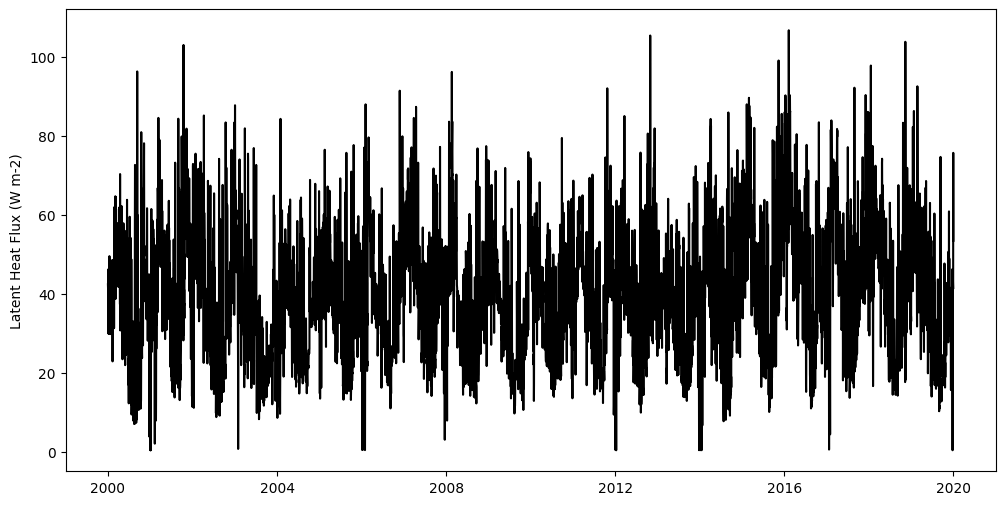

In [15]:
pyplot.figure(figsize = (12, 6))
pyplot.plot(time, prediction[:,0], 'k-')
pyplot.ylabel('Latent Heat Flux (W m-2)')
pyplot.show()